<a href="https://colab.research.google.com/github/eugenetwc/Medium-Notebooks/blob/master/arima_hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA for Hierarchical Time Series Forecasting

## Stationarity

In [1]:
import datapane as dp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed

sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [2]:
date = pd.date_range(start='2020-01-01', end='2020-09-01', freq='D')
y_stationary_1 = np.random.normal(0, 10, size=date.shape)
df_stationary_1 = pd.DataFrame({'y': y_stationary_1}, index=date)
df_stationary_1.head()

,y
2020-01-01,5.241613
2020-01-02,-2.706639
2020-01-03,-5.646717
2020-01-04,37.528974
2020-01-05,10.646366


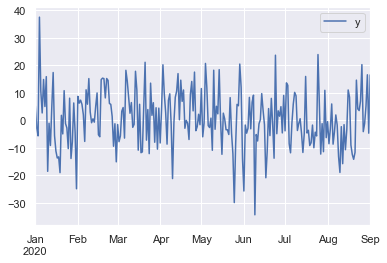

In [3]:
stationary_1_plot = df_stationary_1.plot()

In [4]:
y_stationary_2 = np.random.normal(0, 10, size=date.shape) * np.sin(2 * np.pi * np.arange(date.shape[0]))
df_stationary_2 = pd.DataFrame({'y': y_stationary_2}, index=date)
df_stationary_2.head()

,y
2020-01-01,-0.000000e+00
2020-01-02,-2.653365e-15
2020-01-03,-4.319236e-15
2020-01-04,-5.005538e-15
2020-01-05,-1.229644e-14


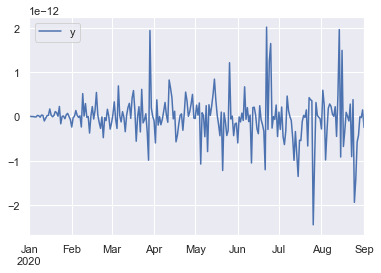

In [5]:
stationary_2_plot = df_stationary_2.plot()

# Download M5 Datset

In [51]:
!kaggle competitions download -c m5-forecasting-accuracy

m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
!unzip m5-forecasting-accuracy.zip

Archive:  m5-forecasting-accuracy.zip
replace calendar.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [43]:
df = pd.read_csv('sales_train_evaluation.csv')
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [44]:
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [65]:
train = df.iloc[0][[f'd_{i}' for i in range(1, 1913+1)]].values.astype(int)
test = df.iloc[0][[f'd_{i}' for i in range(1914, 1941+1)]].values.astype(int)

model = SARIMAX(train, order=(2,1,2), seasonal_order=(1, 0, 1, 7), trend='ct', enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
preds = model_fit.forecast(test.shape[0])

In [66]:
error = MASE(train, test, preds)
print(error)

2.8469985006235534


Text(0.5, 1.0, 'Simple (Bad) Prediction with ARIMA')

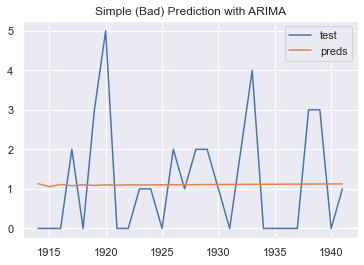

In [67]:
x = range(1, 1941+1)
# plt.plot(x[:1913], train)
arima_sample_plot = plt.figure()
plt.plot(x[1913:], test, label='test')
plt.plot(x[1913:], preds, label='preds')
plt.legend()
plt.title('Simple (Bad) Prediction with ARIMA')

In [52]:
X = df[[f'd_{i}' for i in range(1, 1941+1)]].values[:1, :]
X.shape

(1, 1941)

In [59]:
def evaluate_arima_model(X: np.array, arima_order: list) -> float:
    errors = []
    for row in X:
        train = row[:-28]
        test = row[-28:]
        model = SARIMAX(train, order=arima_order[0], seasonal_order=arima_order[1], trend=arima_order[2], enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        preds = model_fit.forecast(test.shape[0])
        
        mase = MASE(train, test, preds)
        errors.append(mase)
        
    return np.mean(errors)
        
def grid_search(X, param_grid):
    def evaluate(params):
        order = (params['p'], params['q'], params['d'])
        seasonal_order = (params['P'], params['D'], params['Q'], params['m'])
        t = params['t']
        
        order_list = [order, seasonal_order, t]
        try:
            mase = evaluate_arima_model(X, order_list)
            print('ARIMA%s MASE=%.3f' % (order_list, mase))
        except:
            return
            
        return (params, mase)
    
    results = Parallel(n_jobs=4)(delayed(evaluate)(params) for params in ParameterGrid(param_grid))
    results.sort(key=lambda x: x[1])
    
    best_cfg, best_score = results[0]
    
    print('Best SARIMA%s MASE=%.3f' % (best_cfg, best_score))
    
    return best_cfg
        
    

In [60]:
param_grid = {
    'p': [0, 1, 2],
    'q': [0, 1],
    'd': [0, 1, 2],
    't': ['n', 'c', 't', 'ct'],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [7]
}
best_cfg = grid_search(X, param_grid)

Best SARIMA{'D': 1, 'P': 1, 'Q': 0, 'd': 2, 'm': 7, 'p': 2, 'q': 1, 't': 'ct'} MASE=2.518


In [73]:
dp.Report(
    dp.Plot(stationary_1_plot),
    dp.Plot(stationary_2_plot),
    dp.Plot(arima_sample_plot)

).publish(name='ARIMA for Hierarchical Time Series Forecasting', open=True)

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/eugene/reports/arima-for-hierarchical-time-series-forecasting/
